In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst, u_arrays as ua
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
from utils import u_statistics as u_stat
from scipy.stats import norm
import matplotlib.mlab as mlab

coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [14]:
#coref = '/home/ck/DIR/cornkle/MCSfiles/blob_map_allscales_-50_JJAS_points_dominant_daily.nc'

In [15]:
#dat = xr.open_dataarray(coref)

In [44]:
# coresPower_MSG_-40_700km2_-50points_dominant_vcores_14-4W_15UTC.csv
# blob_map_allscales_-50_JJAS_points_dominant_daily.csv
pdic = pd.read_csv('/home/ck/DIR/cornkle/data/NFLICS/tables/coresPower_MSG_-40_700km2_-50points_dominant_vcores_14-4W_15UTC.csv', na_values=[-999])
pdic = pd.DataFrame.from_dict(pdic)

In [7]:
# h=17
# msgopen = pd.read_csv(
#         cnst.network_data + 'figs/LSTA/corrected_LSTA/new/ERA5/core_txt/init_merged2/cores_gt15000km2_table_AMSRE_tracking2_' + str(
#             h) + '_init.csv', na_values=[-999, -99])
# msg = pd.DataFrame.from_dict(msgopen)# &  &
# msg = msg[(msg['lat']>9.5) & (msg['lat']<20.5) & (msg['topo']<=450) & (msg['dtime']<=2)]

In [8]:
#date = pd.to_datetime(msg[['year','month','day', 'hour']])

In [9]:
#msg['date'] = date

In [10]:
#pdic = msg

In [45]:
pdic

,id,date,lon,lat,hour,month,year,day
0,0,2004-03-31 15:00:00,-5.332872,11.390175,15,3,2004,31
1,1,2004-03-31 15:00:00,-4.569304,11.611669,15,3,2004,31
2,2,2004-04-12 15:00:00,-5.737114,10.680237,15,4,2004,12
3,3,2004-04-12 15:00:00,-4.883715,12.230894,15,4,2004,12
4,4,2004-04-16 15:00:00,-9.015965,10.546932,15,4,2004,16
...,...,...,...,...,...,...,...,...
5831,5831,2018-08-29 15:00:00,-10.273607,15.999989,15,8,2018,29
5832,5832,2018-08-30 15:00:00,-4.120147,14.210988,15,8,2018,30
5833,5833,2018-08-31 15:00:00,-4.075231,14.210988,15,8,2018,31
5834,5834,2018-08-31 15:00:00,-4.389641,14.998279,15,8,2018,31


In [46]:
tab = pdic

In [47]:
tab['time'] = tab['date']

In [48]:
tab

,id,date,lon,lat,hour,month,year,day,time
0,0,2004-03-31 15:00:00,-5.332872,11.390175,15,3,2004,31,2004-03-31 15:00:00
1,1,2004-03-31 15:00:00,-4.569304,11.611669,15,3,2004,31,2004-03-31 15:00:00
2,2,2004-04-12 15:00:00,-5.737114,10.680237,15,4,2004,12,2004-04-12 15:00:00
3,3,2004-04-12 15:00:00,-4.883715,12.230894,15,4,2004,12,2004-04-12 15:00:00
4,4,2004-04-16 15:00:00,-9.015965,10.546932,15,4,2004,16,2004-04-16 15:00:00
...,...,...,...,...,...,...,...,...,...
5831,5831,2018-08-29 15:00:00,-10.273607,15.999989,15,8,2018,29,2018-08-29 15:00:00
5832,5832,2018-08-30 15:00:00,-4.120147,14.210988,15,8,2018,30,2018-08-30 15:00:00
5833,5833,2018-08-31 15:00:00,-4.075231,14.210988,15,8,2018,31,2018-08-31 15:00:00
5834,5834,2018-08-31 15:00:00,-4.389641,14.998279,15,8,2018,31,2018-08-31 15:00:00


In [49]:
# file = '/home/ck/DIR/cornkle/data/NFLICS/cell_stats14.2_n18_15.2_n16_Unique_msg9_cell_mean_cellthresh_n70_cellpixlt_n70_freq_mean_00000_refhours_18_21.csv' 
# tab = pd.read_table(file, parse_dates=True, delimiter=',')

In [70]:
def cut_kernel_lsta(xpos, ypos, arr, h):

    dist=100

    kernel = u_arrays.cut_kernel(arr,xpos, ypos,dist)

    if (np.sum(np.isfinite(kernel)) < 0.01 * kernel.size):
        return

    kmean = kernel

    if kernel.shape != (2*dist+1, 2*dist+1):
        print('WRONG SHAPE')
        return
    ycirc30, xcirc30 = u_arrays.draw_circle(dist+1, dist+1,6) # 15km radius
    k30 = np.nanmean(kmean[ycirc30, xcirc30])

    ycirc100e, xcirc100e = u_arrays.draw_circle(dist+51, dist+1, 17)  # at - 150km, draw 50km radius circle
    data = kmean[ycirc100e,xcirc100e]
    
#     if h > 17:
#         x2 = 95 # 285km upstream
#     else:
#         x2 = 80 # 240km
#     data = kernel[dist - 10:dist + 10, dist+8:dist + x2]

    e100 = np.nanmean(data)

#     if (np.sum(np.isfinite(data)) / data.size) < 0.01:
#         print('Too small valid area')
#         return
    
    if np.isnan(e100):
        print('Is nan')
        return

    return k30, e100, kernel

In [78]:
def cut_out(dic, h):
    
    tab = dic[dic.hour==h]
    #tab = tab[::400]
    
    kernel2_list = None
    cnt_list = None

    amsrk30 = []
    amsre100 = []


    ramsrk30 = []
    ramsre100 = []
    
    amskern = None
    ramskern = None
    
    lonl = []
    latl = []
    tlon = []
    tlat = []

    for date in np.unique(tab.time)[0:100]:

        dt = pd.to_datetime(date)

        #ipdb.set_trace()
        fdate = str(dt.year) + str(dt.month).zfill(2) + str(dt.day).zfill(2) 

        lpath = '/home/ck/DIR/cornkle/data/NFLICS/LSTA/netcdf/'

        try:
            #ipdb.set_trace()
            lsta = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_' + fdate + '1700.nc') #sma  #'AMSR_L3_LPRMv05_A_'

        except:
            print('Could not find '+fdate)
            continue


        lsta_da = lsta['lsta']#.values.squeeze()



        print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
        dt.day).zfill(2) + '.nc')
        
        #ax.pcolormesh(lsta_da)
        
        
        ###############################Blob loop
        cores = 0
        
        points = np.array(list(zip(lsta.lon.values.flat, (lsta.lat.values).flat)))
        
        ttab = tab[tab['date']==date]
        
        #ipdb.set_trace()

        for lat, lon in zip(ttab.lat, ttab.lon): #zip([14.7],[ -16.5]):
            
            #ipdb.set_trace()
            
            print('Doing ', lat, lon)
            
            #ax.set_title(str(lat)+' '+ str(lon))
            
            pout = ua.closest_point((lon, lat), points)
            spos = np.unravel_index(pout, lsta.lon.values.shape)
            
            ypos = spos[0]
            xpos = spos[1]
            
           # ax.plot(xpos, ypos, 'bo')
            #ax.text(xpos, ypos+5, str(lat)+' '+ str(lon))

#             try:
#                 point = lsta_da.sel(lat=lat, lon=lon, method='nearest', tolerance=0.035)
#             except KeyError:
#                 print('Nearest point finding error')
#                 continue

#             plat = point['lat'].values
#             plon = point['lon'].values

#             xpos = np.where(lsta_da['lon'].values == plon)
#             xpos = int(xpos[0])
#             ypos = np.where(lsta_da['lat'].values == plat)
#             ypos = int(ypos[0])

            try:
                ak30, ae100, kernel = cut_kernel_lsta(xpos, ypos, lsta_da.values, h)
            except TypeError:
                print('AMSR kernel error')
                continue

            amsrk30.append(ak30)
            amsre100.append(ae100)


            if amskern is not None:
                amskern = np.nansum(np.stack([amskern, kernel]), axis=0)
                amskernc = np.nansum(np.stack([amskernc,np.isfinite(kernel).astype(int)]), axis=0)
            else:
                amskern = kernel
                amskernc = np.isfinite(kernel).astype(int)
                
            
            lonl.append(lon)
            latl.append(lat)
            tlon.append(lsta.lon.values[ypos,xpos])
            tlat.append(lsta.lat.values[ypos,xpos])

            cores += 1

            ##### random

            y = ypos
            x = xpos

            rdist = 50
            randy50 = [y - rdist, y - rdist, y - rdist, y, y, y + rdist, y + rdist, y + rdist]
            randx50 = [x - rdist, x, x + rdist, x - rdist, x + rdist, x - rdist, x, x + rdist]
            randy50_100 = [y - rdist, y - rdist, y, y, y + rdist, y + rdist]

            rdist = 100
            randx100 = [x - rdist, x + rdist, x - rdist, x + rdist, x - rdist, x + rdist]

            rdist = 150
            randx150 = [x - rdist, x + rdist, x - rdist, x + rdist, x - rdist, x + rdist]
            
            rdist = 200
            randx200 = [x - rdist, x + rdist, x - rdist, x + rdist, x - rdist, x + rdist]

            randy = np.array(randy50 + randy50_100 + randy50_100)
            randx = np.array(randx50 + randx100 + randx150)
            
            for ry, rx in zip(randy,randx):
                
               # ax.plot(rx, ry, 'ro')

                if ry < 0:
                    continue
                if ry > lsta_da.shape[0] - 1:
                    continue

                if rx < 0:
                    continue
                if rx > lsta_da.shape[1] - 1:
                    continue

                try:
                    arc30, arce100, rkernel = cut_kernel_lsta(rx, ry, lsta_da.values, h)
                except TypeError:
                    continue

                ramsrk30.append(arc30)
                ramsre100.append(arce100)
                
                
            if ramskern is not None:
                ramskern = np.nansum(np.stack([ramskern, rkernel]), axis=0)
                ramskernc = np.nansum(np.stack([ramskernc,np.isfinite(rkernel).astype(int)]), axis=0)
            else:
                ramskern = rkernel
                ramskernc = np.isfinite(rkernel).astype(int)
                
            print('Core lonlat', xpos,ypos)
            print ('Random lonlat', rx, ry)

        #ipdb.set_trace()      
        del lsta
        del lsta_da
            
    ams_sum = amskern #np.nansum(np.stack(amskern, axis=0), axis=0)[np.newaxis,...]
    ams_cnt = amskernc #np.sum(np.isfinite(np.stack(amskern, axis=0)), axis=0)[np.newaxis,...]
    
    rams_sum = ramskern #np.nansum(np.stack(ramskern, axis=0), axis=0)[np.newaxis,...]
    rams_cnt = ramskernc #np.sum(np.isfinite(np.stack(ramskern, axis=0)), axis=0)[np.newaxis,...]
   
    dic = {'amsr' : [amsrk30,amsre100],
           'ramsr' : [ramsrk30, ramsre100],
           'akern' : [ams_sum, ams_cnt],
           'rkern' : [rams_sum, rams_cnt],
           'ccord' : [lonl, latl],
           'tcord' : [tlon, tlat]
          }
    
    return dic

In [79]:
dic = cut_out(tab, 15)


Could not find 20040331
Could not find 20040412
Could not find 20040416
Could not find 20040417
Could not find 20040418
Could not find 20040423
Could not find 20040425
Could not find 20040427
Doing AMSR_20040505.nc
Doing  10.902278377506606 -4.43455720083862
Is nan
AMSR kernel error
Doing AMSR_20040512.nc


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


Doing  11.168506869321382 -4.883714842898381
Core lonlat 541 407
Random lonlat 691 457
Doing AMSR_20040515.nc
Doing  11.301528780956955 -5.69219859860595
Is nan
Is nan
Is nan
Is nan
Core lonlat 512 412
Random lonlat 662 462
Doing  12.275068895880704 -5.557451305988021
Is nan
Core lonlat 518 447
Random lonlat 668 497
Doing  12.36339650851702 -5.063377899722285
Is nan
Core lonlat 536 450
Random lonlat 686 500
Doing  12.628197232283654 -4.524388729250572
Is nan
Is nan
Core lonlat 555 459
Random lonlat 705 509
Doing AMSR_20040523.nc
Doing  10.85788332546466 -12.609226286326265
Is nan
Core lonlat 266 394
Random lonlat 416 444
Doing  11.345855566958786 -9.46512279190794
Core lonlat 377 413
Random lonlat 527 463
Doing  11.611669044587902 -5.826945891223878
Is nan
Is nan
Core lonlat 508 423
Random lonlat 658 473
Doing  11.921460309374607 -10.408353840233435
Core lonlat 345 433
Random lonlat 495 483
Doing  11.96568720351881 -4.254894144014715
Is nan
Is nan
Is nan
Is nan
Core lonlat 564 436
Rand

Doing  10.546932258643276 -12.788889343150167
Is nan
Is nan
Is nan
Is nan
Is nan
Is nan
Is nan
Is nan
Is nan
Is nan
Is nan
Core lonlat 259 383
Random lonlat 409 433
Doing  10.680236534856453 -7.713407987874872
AMSR kernel error
Doing AMSR_20040709.nc
Doing  12.09832382465705 -9.959196198173675
Core lonlat 361 439
Random lonlat 511 489
Doing  12.186711267157385 -7.9379868089047525
Core lonlat 433 443
Random lonlat 583 493
Doing  12.628197232283654 -8.701554800406345
Core lonlat 406 458
Random lonlat 556 508
Doing  14.823573574030988 -10.58801689705734
Core lonlat 344 535
Random lonlat 494 585
Doing AMSR_20040710.nc
Doing  10.680236534856453 -11.351584888558936
Is nan
Is nan
Is nan
Is nan
Is nan
Core lonlat 310 388
Random lonlat 460 438
Doing  11.03542316889424 -11.890574059030644
Is nan
Is nan
Is nan
Is nan
Core lonlat 291 401
Random lonlat 441 451
Doing  11.39017538443784 -12.474478993708336
Is nan
Is nan
Is nan
Core lonlat 271 413
Random lonlat 421 463
Doing  12.495831205652706 -11.98

Is nan
Is nan
Core lonlat 464 427
Random lonlat 614 477
Doing  11.877226114054382 -7.62357645946292
Is nan
Core lonlat 443 432
Random lonlat 593 482
Doing  12.186711267157385 -7.264250345815112
Core lonlat 457 443
Random lonlat 607 493
Doing AMSR_20040806.nc
Doing  15.434408809086909 -4.344725672426668
Core lonlat 564 558
Random lonlat 714 608
Doing  15.695643501757145 -6.9049242321673026
Core lonlat 474 566
Random lonlat 624 616
Doing  15.695643501757145 -6.0066089480477824
Core lonlat 505 567
Random lonlat 655 617
Doing AMSR_20040807.nc
Doing  10.902278377506606 -10.767679953881245
Is nan
AMSR kernel error
Doing  10.902278377506606 -8.836302093024273
Is nan
Is nan
Is nan
Is nan
Is nan
Is nan
Core lonlat 399 397
Random lonlat 549 447
Doing  11.03542316889424 -9.914280433967699
Is nan
AMSR kernel error
Doing AMSR_20040808.nc
Doing  11.478794010974235 -5.422704013370093
Is nan
AMSR kernel error
Doing  11.96568720351881 -5.018462135516309
Is nan
AMSR kernel error
Doing  12.18671126715738

Is nan
Is nan
Is nan
Core lonlat 284 563
Random lonlat 434 613
Doing AMSR_20040901.nc
Doing  10.546932258643276 -7.848155280492799
Is nan
Is nan
Is nan
Core lonlat 434 384
Random lonlat 584 434
Doing  10.769073194677787 -8.611723271994395
Is nan
Is nan
Is nan
Is nan
Is nan
Is nan
Core lonlat 407 392
Random lonlat 557 442
Doing  11.434488207675411 -11.62107947379479
Is nan
Is nan
Is nan
Is nan
Is nan
Is nan
Is nan
Core lonlat 301 415
Random lonlat 451 465
Doing  12.451693903120821 -5.557451305988021
Core lonlat 518 453
Random lonlat 668 503
Doing AMSR_20040902.nc
Doing  10.591373554169657 -4.5693044934565465
Is nan
Is nan
Is nan
Core lonlat 552 387
Random lonlat 702 437
Doing  11.25719505217237 -4.030315322984835
Is nan
Is nan
Is nan
Core lonlat 572 410
Random lonlat 722 460
Doing  11.434488207675411 -11.935489823236626
Is nan
Is nan
Is nan
Is nan
Core lonlat 290 415
Random lonlat 440 465
Doing  12.804577275174506 -4.299809908220691
Is nan
Core lonlat 563 465
Random lonlat 713 515
Doing

Core lonlat 373 430
Random lonlat 523 480
Doing  11.96568720351881 -11.890574059030644
Core lonlat 293 434
Random lonlat 443 484
Doing  12.23089382089406 -10.543101132851367
Core lonlat 341 444
Random lonlat 491 494
Doing  12.451693903120821 -4.928630607104356
Core lonlat 541 453
Random lonlat 691 503
Doing AMSR_20041012.nc
Doing  11.168506869321382 -13.55245733465176
Is nan
Is nan
Core lonlat 233 405
Random lonlat 383 455
Doing  11.611669044587902 -12.474478993708336
Is nan
Core lonlat 272 421
Random lonlat 422 471
Doing  14.473734944663706 -8.881217857230249
Core lonlat 403 523
Random lonlat 553 573
Doing AMSR_20041013.nc
Doing  10.85788332546466 -13.46262580623981
Is nan
Is nan
Is nan
Core lonlat 236 394
Random lonlat 386 444
Doing  12.407548995680294 -8.926133621436225
Core lonlat 398 451
Random lonlat 548 501
Doing  12.848652834524069 -8.297312922552562
Core lonlat 421 466
Random lonlat 571 516
Doing AMSR_20041015.nc
Doing  10.769073194677787 -12.384647465296386
Is nan
Core lonlat

In [80]:
dic

{'amsr': [[3.2583486238532107,
   0.31324074074074065,
   5.520176991150442,
   5.598938053097345,
   6.0016814159292045,
   -2.79125,
   1.01,
   0.1781818181818182,
   1.3580530973451326,
   0.48999999999999994,
   0.04879310344827582,
   1.3504444444444446,
   -1.658230088495575,
   -0.3800884955752213,
   1.3153982300884954,
   3.498938053097345,
   0.24999999999999994,
   nan,
   nan,
   -5.837999999999999,
   -4.453164556962025,
   0.3134408602150538,
   1.6947787610619471,
   0.3275221238938053,
   3.196991150442478,
   3.0828318584070797,
   0.588018018018018,
   -0.7460176991150442,
   2.03283185840708,
   2.899823008849557,
   1.0318584070796462,
   0.6342477876106195,
   -3.052920353982301,
   0.730353982300885,
   -0.7177142857142855,
   1.4972566371681413,
   0.32964601769911506,
   2.7997345132743363,
   0.0751923076923077,
   1.5086725663716813,
   0.685929203539823,
   -4.027954545454546,
   -2.3057446808510638,
   3.8789814814814814,
   1.185,
   0.8730882352941176,
  

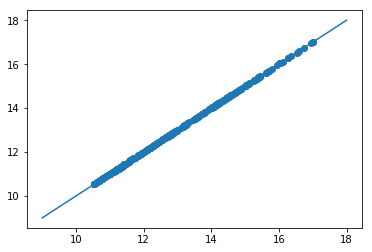

In [81]:
plt.scatter(dic['ccord'][1], dic['tcord'][1])
plt.plot(np.arange(9,19), np.arange(9,19))

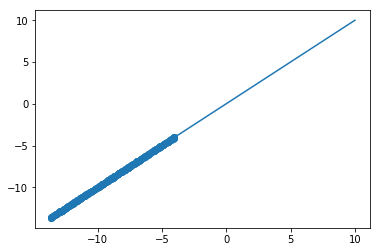

In [82]:
plt.scatter(dic['ccord'][0], dic['tcord'][0])
plt.plot(np.arange(-10,11), np.arange(-10,11))

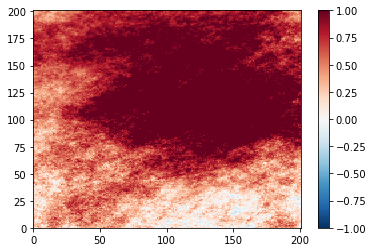

In [85]:
plt.pcolormesh((dic['akern'][0]).squeeze()/(dic['akern'][1]).squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

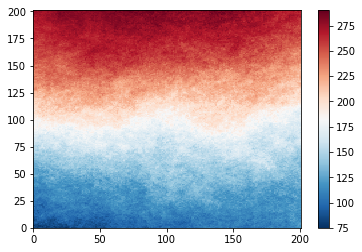

In [86]:
plt.pcolormesh((dic['akern'][1]).squeeze(), cmap='RdBu_r')
plt.colorbar()


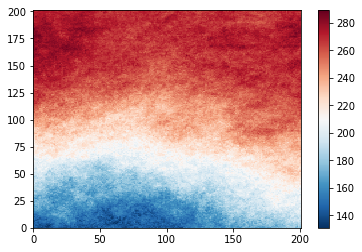

In [87]:
plt.pcolormesh((dic['rkern'][1]).squeeze(), cmap='RdBu_r')
plt.colorbar()

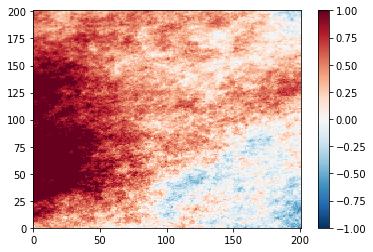

In [88]:
plt.pcolormesh((dic['rkern'][0]).squeeze()/(dic['rkern'][1]).squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

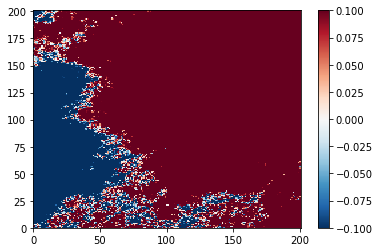

In [89]:
plt.pcolormesh((dic['akern'][0]).squeeze()/(dic['akern'][1]).squeeze()-(dic['rkern'][0]).squeeze()/(dic['rkern'][1]).squeeze(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
plt.colorbar()

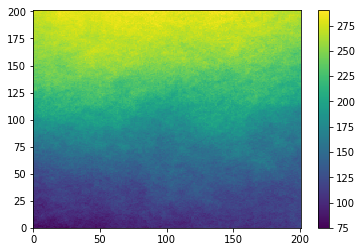

In [90]:
plt.pcolormesh((dic['akern'][1]).squeeze())
plt.colorbar()

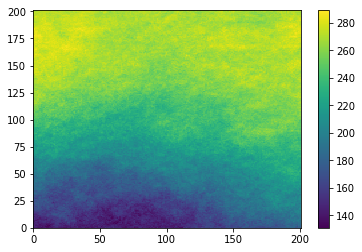

In [91]:
plt.pcolormesh((dic['rkern'][1]).squeeze())
plt.colorbar()

[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9]
58.95% of Cells occur in warmest half


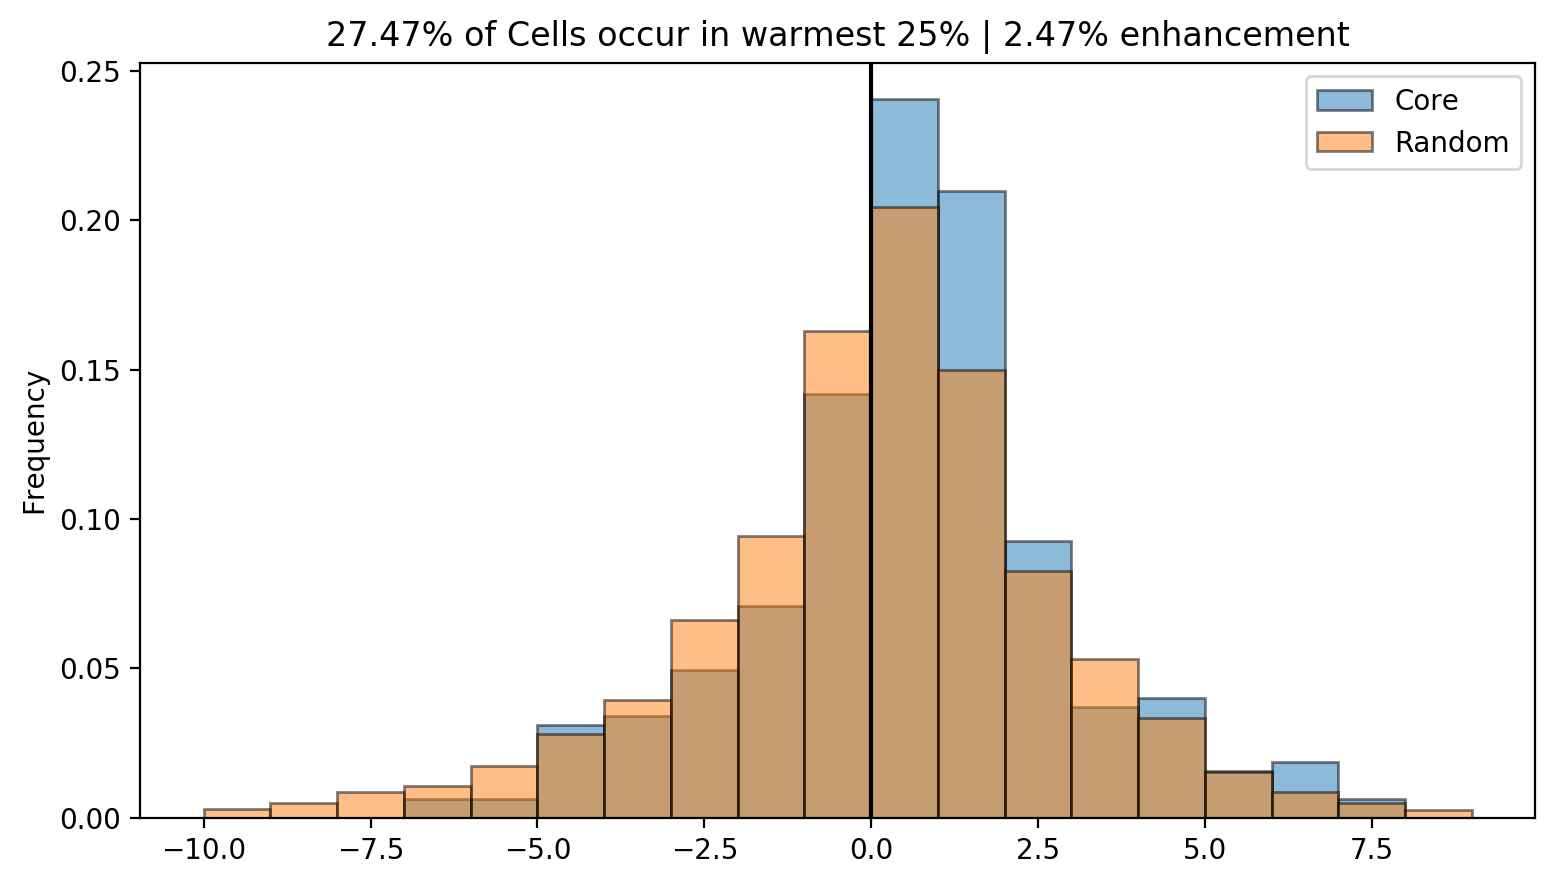

In [92]:
cinput = np.array(dic['amsr'][1])
rinput = np.array(dic['ramsr'][1])
point = cinput[np.isfinite(cinput)]
all = rinput[np.isfinite(rinput)]

nbpoint, pointcount, bins = u_stat.histo_frequency(point, bins=np.arange(-10,10,1))
nball, allcount, bins = u_stat.histo_frequency(all, bins=np.arange(-10, 10, 1))
print(bins)
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
bin_edge = bins[0:-1]
width = bins[1::] - bins[0:-1]

f = plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111)

ax.bar(bin_edge, nbpoint, label='Core', edgecolor='k', alpha=0.5, align='edge', width=width)
ax.bar(bin_edge, nball, label='Random', edgecolor='k', alpha=0.5, align='edge', width=width)
plt.ylabel('Frequency')
#ipdb.set_trace()
stri = (np.sum(point >= np.percentile(all, 75)) / point.size * 100).round(2)
plt.title(str(stri)+'% of Cells occur in warmest 25% | '+ str(np.round(stri-25,2))+'% enhancement')
plt.legend()

stri = (np.sum(point >= np.percentile(all, 50)) / point.size * 100).round(2)
print(str(stri) + '% of Cells occur in warmest half')

plt.axvline(0, color='k')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_prob.png')

In [258]:
# best fit of data
(mupoint, sigmapoint) = norm.fit(point)
(muall, sigmaall) = norm.fit(all)

# add a 'best fit' line
ypoint = mlab.normpdf( bins, mupoint, sigmapoint)
yall = mlab.normpdf(bins, muall, sigmaall)

# add a 'best fit' line
cypoint = norm.cdf( bins, mupoint, sigmapoint)
cyall = norm.cdf(bins, muall, sigmaall)

print('Core', norm.pdf(0,mupoint,sigmapoint))
print('Random', norm.pdf(0,muall,sigmaall))


Core 0.12346729407167924
Random 0.151880569360824


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


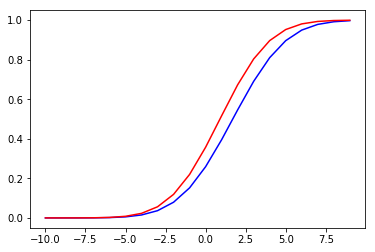

In [259]:
plt.plot(bins,cypoint, 'b')
plt.plot(bins, cyall, 'r')

65.12% of Cells occur in warmest half


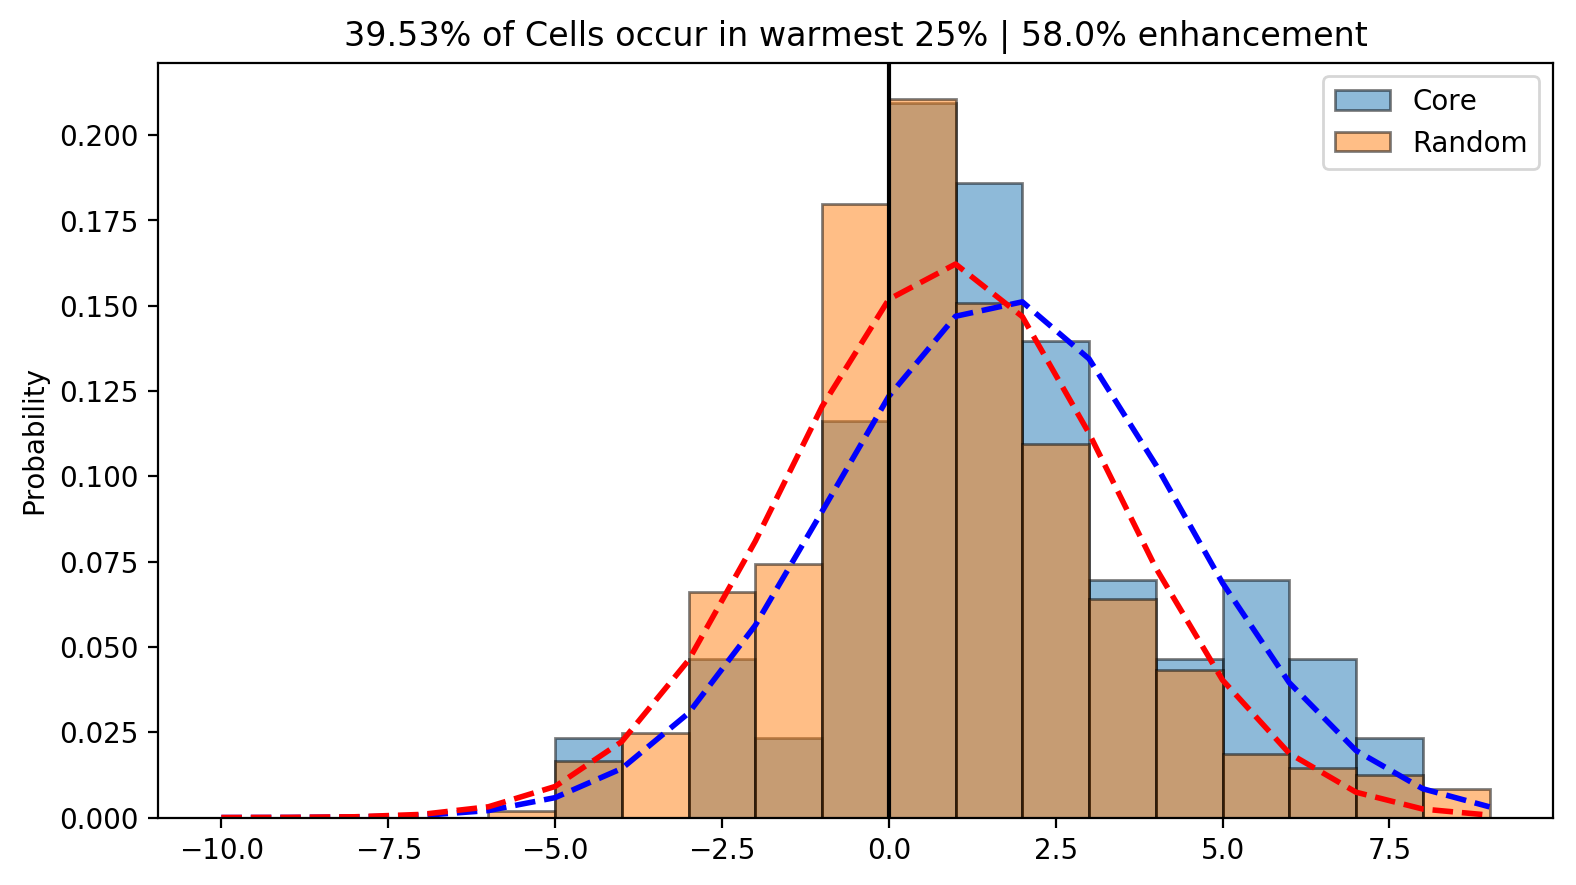

In [313]:
f = plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111)

ax.bar(bin_edge, nbpoint, label='Core', edgecolor='k', alpha=0.5, align='edge', width=width)
ax.bar(bin_edge, nball, label='Random', edgecolor='k', alpha=0.5, align='edge', width=width)

plt.plot(bins, ypoint, 'b--', linewidth=2)
plt.plot(bins, yall, 'r--', linewidth=2)

plt.ylabel('Probability')
stri = (np.sum(cinput >= np.percentile(rinput, 75)) / cinput.size * 100).round(2)
enh = (stri-25)/25*100
plt.title(str(stri)+'% of Cells occur in warmest 25% | '+ str(np.round(enh))+'% enhancement')
plt.legend()

stri = (np.sum(cinput >= np.percentile(rinput, 50)) / cinput.size * 100).round(2)
print(str(stri) + '% of Cells occur in warmest half')

plt.axvline(0, color='k')
f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_prob_fit.png')

In [329]:
def calc_prob(x, mu_core, mu_random, sigma_core, sigma_random):
    
    corep = norm.pdf(x,mu_core,sigma_core)
    randomp = norm.pdf(x,mu_random,sigma_random)
    
    corec = norm.cdf(x,mu_core,sigma_core)
    randomc = norm.cdf(x,mu_random,sigma_random)
    
    out_pdf = (corep - randomp)/randomp

    prob_factor = 1+out_pdf

    return out_pdf, prob_factor

In [332]:
calc_prob(1, mupoint, muall, sigmapoint, sigmaall)

(-0.09439285268274139, 0.9056071473172587)

In [337]:
prob = []
factor = []
for b in bins:
    tb, fac = calc_prob(b, mupoint, muall, sigmapoint, sigmaall)
    prob.append(tb)
    factor.append(fac)

In [339]:
factor

[0.8364503905578802,
 0.7617679993760319,
 0.7078740964245995,
 0.6711816508237186,
 0.6493440849902175,
 0.6410035899208362,
 0.6456494626030977,
 0.6635656328670674,
 0.695859780106181,
 0.7445782486138184,
 0.812923566136738,
 0.9056071473172587,
 1.0293918567874523,
 1.1939121569576283,
 1.4129109131904287,
 1.7061135961553915,
 2.102092716173312,
 2.6426919997404603,
 3.389939845308801,
 4.436987370651416]

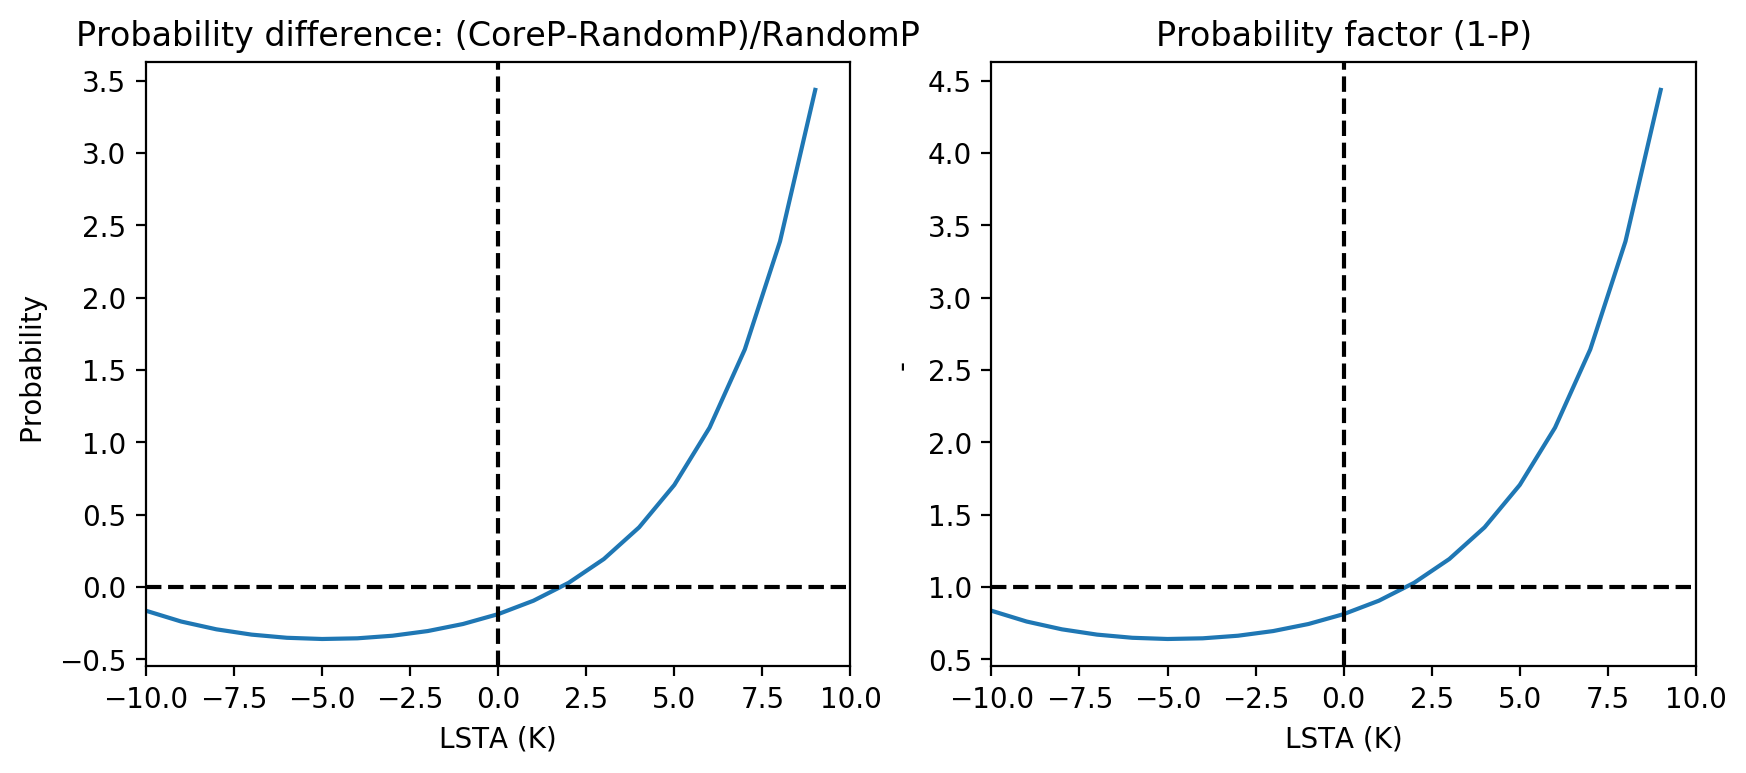

In [356]:
f = plt.figure(figsize=(10,4), dpi=200)
ax = f.add_subplot(121)
plt.plot(bins,np.array(prob))
plt.ylabel('Probability ')
plt.axhline(0,color='k', linestyle='dashed')
plt.axvline(0,color='k', linestyle='dashed')
plt.xlim(-10,10)
plt.xlabel('LSTA (K)')
plt.title('Probability difference: (CoreP-RandomP)/RandomP')

ax = f.add_subplot(122)
plt.plot(bins,np.array(factor))
plt.ylabel('-')
plt.axhline(1,color='k', linestyle='dashed')
plt.axvline(0,color='k', linestyle='dashed')
plt.xlim(-10,10)
plt.xlabel('LSTA (K)')
plt.title('Probability factor (1-P)')
f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/p_change.png')

In [349]:
testlsta = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_200806191700.nc')

In [350]:
testlsta

<xarray.Dataset>
Dimensions:  (lat: 714, lon: 1436)
Coordinates:
  * lat      (lat) float64 0.0 0.02805 0.0561 0.08415 ... 19.92 19.94 19.97 20.0
  * lon      (lon) float64 -20.0 -19.97 -19.94 -19.92 ... 19.92 19.94 19.97 20.0
Data variables:
    lsta     (lat, lon) float64 ...
    NbSlot   (lat, lon) int16 ...

In [351]:
testlsta = testlsta.sel(lat=slice(10,20), lon=slice(-17.2,-2))

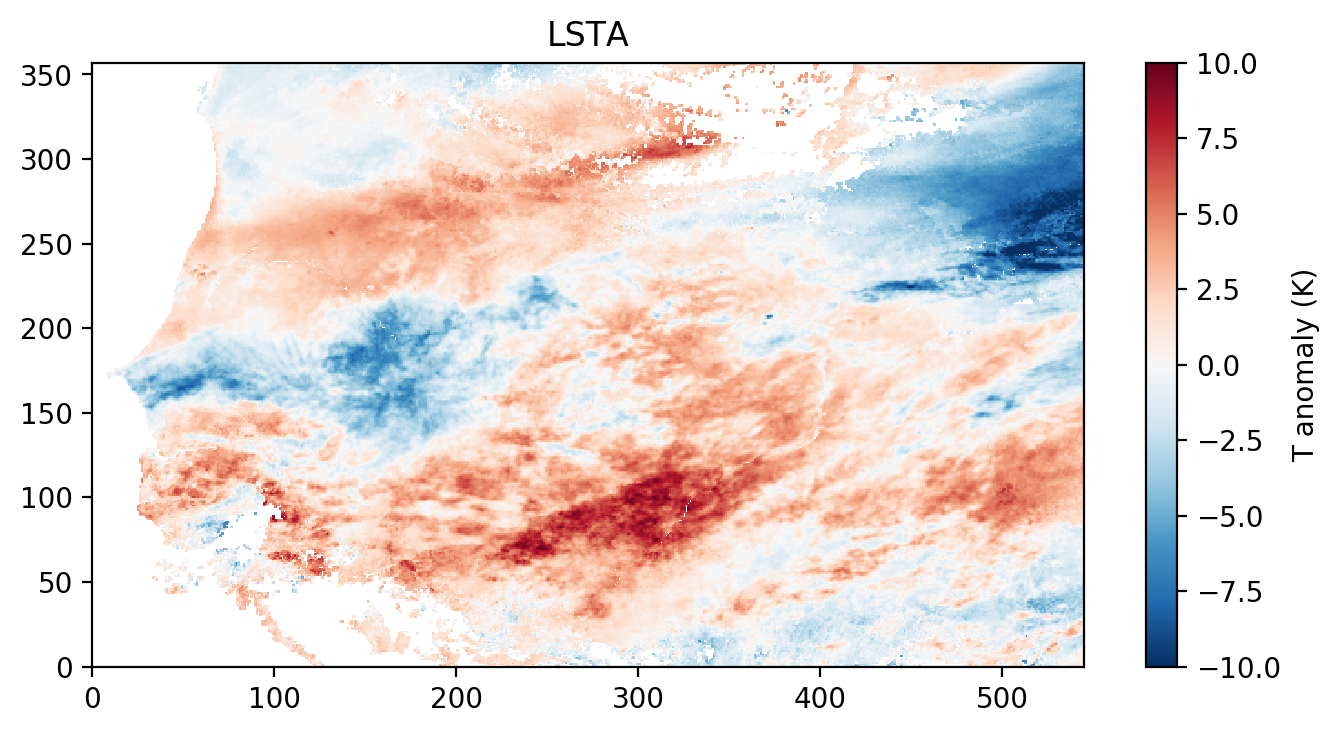

In [352]:
f=plt.figure(figsize=(8,4), dpi=200)
plt.pcolormesh(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
plt.title('LSTA')
cbar = plt.colorbar()
cbar.set_label('T anomaly (K)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map.png')

In [318]:
probability_map = np.zeros_like(testlsta['lsta'].values)*np.nan

In [353]:
for i in range(probability_map.shape[0]):
    for j in range(probability_map.shape[1]):
        p, fac = calc_prob(testlsta['lsta'].values[i,j], mupoint, muall, sigmapoint, sigmaall)
        probability_map[i,j] = fac
        

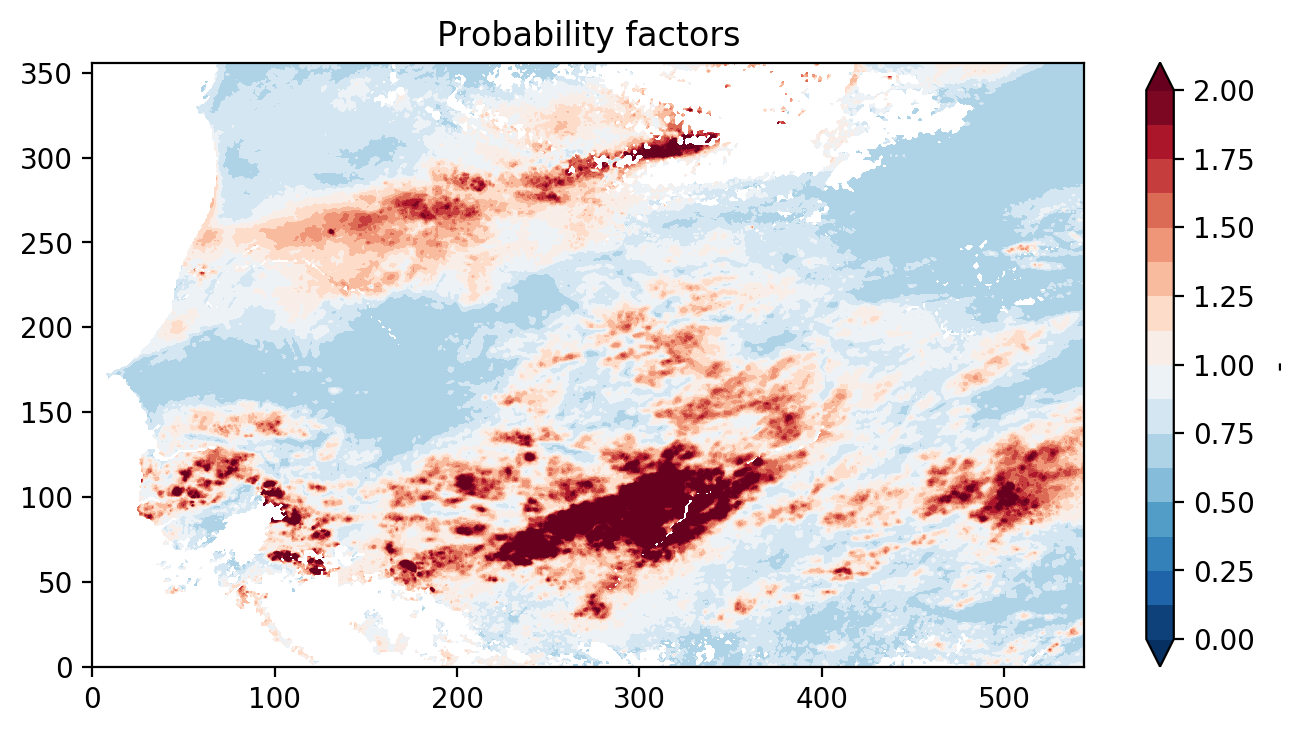

In [355]:
f=plt.figure(figsize=(8,4), dpi=200)
plt.contourf(probability_map, cmap='RdBu_r',levels=np.linspace(0,2,17), extend='both')
#plt.contour(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
plt.title('Probability factors')
cbar = plt.colorbar()
cbar.set_label('-')
f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map_probability.png')

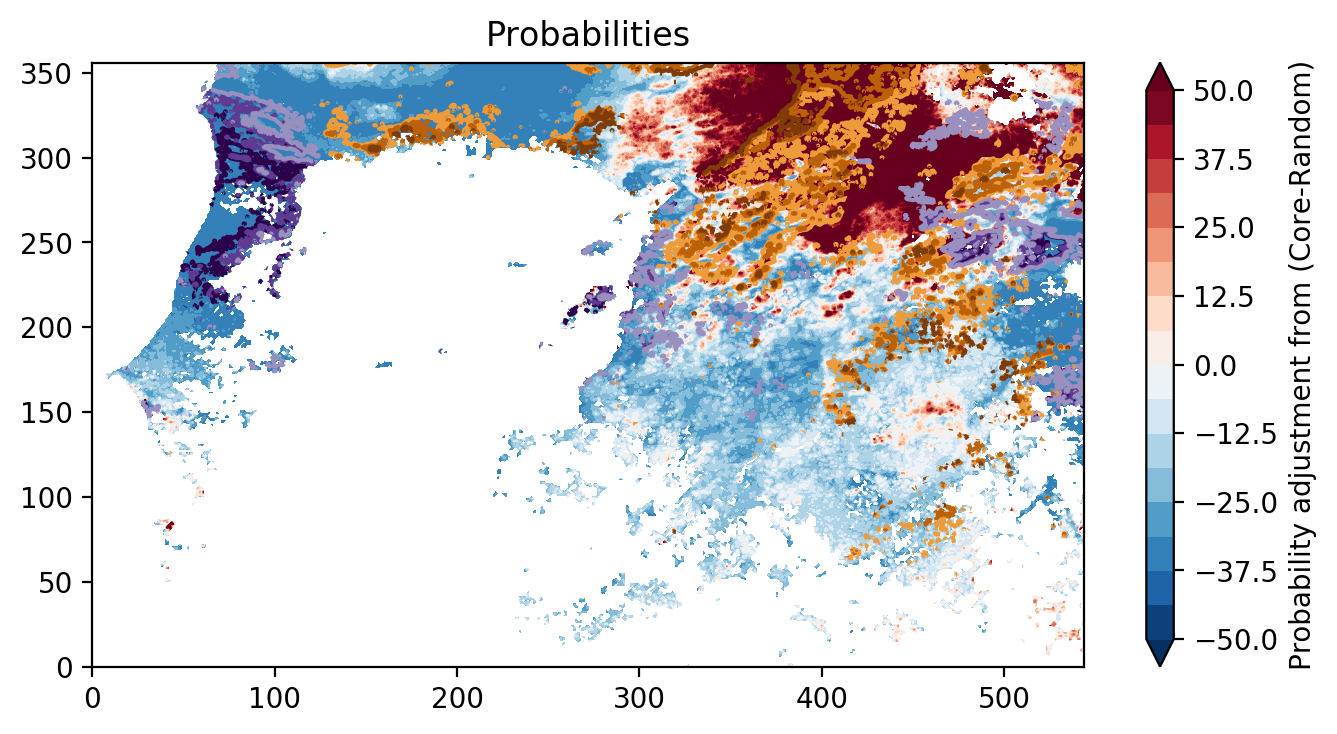

In [304]:
f=plt.figure(figsize=(8,4), dpi=200)
plt.contourf(probability_map, cmap='RdBu_r',levels=np.linspace(-50,50,17), extend='both')
#plt.contour(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
cbar = plt.colorbar()
plt.contour(testlsta1['lsta'].values-testlsta['lsta'].values, cmap='PuOr_r', levels=[-8,-6,-4,4,6,8], extend='both')

plt.title('Probabilities')

cbar.set_label('Probability adjustment from (Core-Random)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map_probability.png')

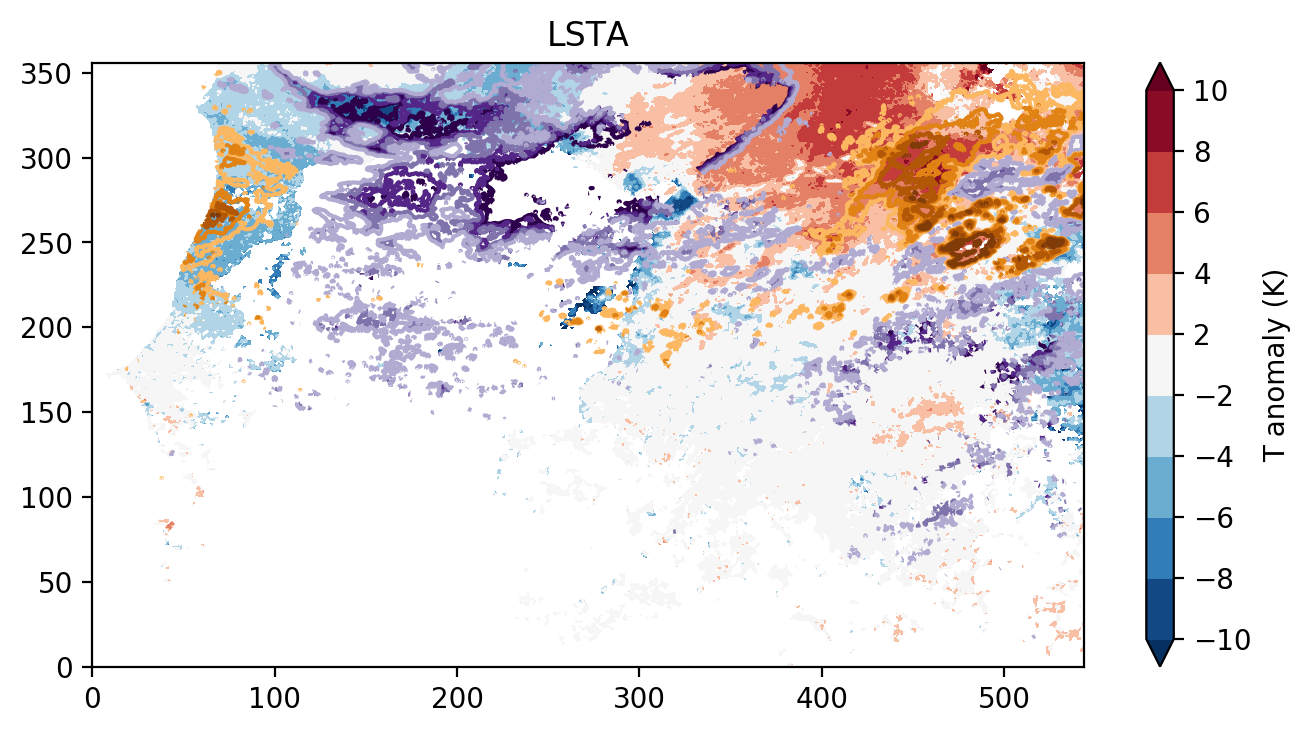

In [303]:
testlsta1 = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_201208251700.nc')
testlsta1 = testlsta1.sel(lat=slice(10,20), lon=slice(-17.2,-2))
f=plt.figure(figsize=(8,4), dpi=200)
plt.contourf(testlsta1['lsta'].values, cmap='RdBu_r', levels=[-10,-8,-6,-4,-2,2,4,6,8,10], extend='both')

plt.title('LSTA')
cbar = plt.colorbar()
plt.contour(testlsta['lsta'].values, cmap='PuOr_r', levels=[-10,-8,-6,-4,4,6,8,10])
cbar.set_label('T anomaly (K)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map.png')

In [ ]:
def normcdf(x, mu, sigma):
    t = x-mu;
    y = 0.5*erfcc(-t/(sigma*sqrt(2.0)));
    if y>1.0:
        y = 1.0;
    return y

def normpdf(x, mu, sigma):
    u = (x-mu)/abs(sigma)
    y = (1/(sqrt(2*pi)*abs(sigma)))*exp(-u*u/2)
    return y

def normdist(x, mu, sigma, f):
    if f:
        y = normcdf(x,mu,sigma)
    else:
        y = normpdf(x,mu,sigma)
    return y